In [1]:
import time
import h5py
import matplotlib.pyplot as plt
from scipy import ndimage
from dnn_app_utils_v3 import *
from public_tests import *
import os
import json
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf
from tensorflow.keras import layers, models

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

In [3]:
# Set your directory path where the images are stored
image_dir = r'D:\ML Projects\CNN Classification\W4A2\Classifier_2\BalancedAugmentedDataset'
data = []

# Iterate through each type of waste folder
for waste_type in os.listdir(image_dir):
    type_path = os.path.join(image_dir, waste_type)
    if os.path.isdir(type_path):
        # Iterate through each image in the waste type folder
        for image_name in os.listdir(type_path):
            if image_name.endswith(('.png', '.jpg', '.jpeg')):  # Add any other image formats as needed
                image_path = os.path.join(type_path, image_name)
                data.append({
                    'file_name': image_name,
                    'path': image_path,
                    'type': waste_type
                })

# Shuffle the dataset
np.random.seed(42)  # For reproducibility
np.random.shuffle(data)

# Create lists for X and y
X = [entry['path'] for entry in data]  # Image paths
y = [entry['type'] for entry in data]   # Corresponding labels

# Encode the labels as integers and store the names
unique_classes = list(set(y))
class_mapping = {cls: idx for idx, cls in enumerate(unique_classes)}
y_encoded = [class_mapping[label] for label in y]
y_names = [unique_classes[label] for label in y_encoded]  # Store original names corresponding to encoded labels

# Split the data into training (60%), validation (20%), and testing (20%)
train_x, temp_x, train_y, temp_y, train_y_names, temp_y_names = train_test_split(X, y_encoded, y_names, test_size=0.4, random_state=42)
val_x, test_x, val_y, test_y, val_y_names, test_y_names = train_test_split(temp_x, temp_y, temp_y_names, test_size=0.5, random_state=42)

# Create a dataset dictionary
dataset = {
    'train': {'X': train_x, 'y': train_y, 'y_names': train_y_names},
    'validation': {'X': val_x, 'y': val_y, 'y_names': val_y_names},
    'test': {'X': test_x, 'y': test_y, 'y_names': test_y_names},
    'class_mapping': class_mapping  # Include class mapping for reference
}

# Save the dataset to a JSON file
json_file_path = 'waste_images_dataset_split.json'
with open(json_file_path, 'w') as json_file:
    json.dump(dataset, json_file, indent=4)

print(f"Dataset split into train, validation, and test sets and saved to {json_file_path}.")


Dataset split into train, validation, and test sets and saved to waste_images_dataset_split.json.


Image shape: (277, 277, 3)
y = 6. It's a Plastic picture.


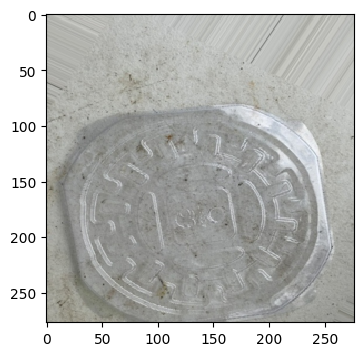

In [4]:
# Load the dataset from the JSON file
json_file_path = 'waste_images_dataset_split.json'

with open(json_file_path, 'r') as json_file:
    dataset = json.load(json_file)

# Example of using the training set
train_data = dataset['train']
train_x = train_data['X']  # Image paths
train_y = train_data['y']   # Labels

# Choose an index to display an image
index = 389
num_px = 277

# Load the image from the specified path
image_path = train_x[index]
image = Image.open(image_path).resize((num_px, num_px))  # Resize as necessary
plt.imshow(image)

# Print the shape of the image
print("Image shape:", np.array(image).shape)

# Get the corresponding label
label = train_y_names[index]
label_number = train_y[index]
print("y = " + str(label_number) + ". It's a " + label + " picture.")
classes = ["Glass", "Plastic", "Metal", "Miscellaneous Trash", "Cardboard", "Food Organics", "Textile Trash", "Paper", "Vegetation"]


In [5]:
from sklearn.preprocessing import OneHotEncoder
import numpy as np
from PIL import Image
import json

# Load the dataset from the JSON file
json_file_path = 'waste_images_dataset_split.json'

with open(json_file_path, 'r') as json_file:
    dataset = json.load(json_file)

# Extract the training and testing data
train_data = dataset['train']
test_data = dataset['test']

# Set the number of pixels for resizing images
num_px = 256  # Example pixel size for resizing images

# Prepare the data for exploration with names included
train_x = np.array([np.array(Image.open(image_path).resize((num_px, num_px))) / 255.0 for image_path in train_data['X']])
train_y = np.array(train_data['y'])
train_y_names = np.array(train_data['y_names'])  # Add names for training set

test_x = np.array([np.array(Image.open(image_path).resize((num_px, num_px))) / 255.0 for image_path in test_data['X']])
test_y = np.array(test_data['y'])
test_y_names = np.array(test_data['y_names'])  # Add names for testing set

# One-hot encode the labels
encoder = OneHotEncoder(sparse_output=False, categories='auto')  # Replace sparse with sparse_output
train_y_one_hot = encoder.fit_transform(train_y.reshape(-1, 1))  # Reshape for encoder
test_y_one_hot = encoder.transform(test_y.reshape(-1, 1))  # Use transform on test set

# Explore your dataset
m_train = train_x.shape[0]
num_px = train_x.shape[1]  # Assuming square images
m_test = test_x.shape[0]

print("Number of training examples: " + str(m_train))
print("Number of testing examples: " + str(m_test))
print("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print("train_x shape: " + str(train_x.shape))
print("train_y shape (original): " + str(train_y.shape))
print("train_y shape (one-hot): " + str(train_y_one_hot.shape))
print("test_x shape: " + str(test_x.shape))
print("test_y shape (original): " + str(test_y.shape))
print("test_y shape (one-hot): " + str(test_y_one_hot.shape))


Number of training examples: 8586
Number of testing examples: 2862
Each image is of size: (256, 256, 3)
train_x shape: (8586, 256, 256, 3)
train_y shape (original): (8586,)
train_y shape (one-hot): (8586, 9)
test_x shape: (2862, 256, 256, 3)
test_y shape (original): (2862,)
test_y shape (one-hot): (2862, 9)


In [5]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras import layers, models

# Load the ResNet50 model with pre-trained ImageNet weights
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
num_classes = 9

# Add custom classification layers
x = layers.GlobalAveragePooling2D()(base_model.output)
x = layers.Dense(128, activation='relu')(x)
output = layers.Dense(num_classes, activation='softmax')(x)

# Build the new model
model = models.Model(inputs=base_model.input, outputs=output)
model.summary()

C:\Users\MSI KATANA\AppData\Local\Temp\ipykernel_24572\2437547900.py:5: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(256, 256, 3))


17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 23s 1us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 128, 128, 32)   │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_bn (BatchNormalization)   │ (None, 128, 128, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_relu (ReLU)               │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1 (DepthwiseConv2D)     │ (None, 128, 128, 32)   │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_bn                    │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_relu (ReLU)           │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1 (Conv2D)              │ (None, 128, 128, 64)   │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_bn                    │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_relu (ReLU)           │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pad_2 (ZeroPadding2D)      │ (None, 129, 129, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2 (DepthwiseConv2D)     │ (None, 64, 64, 64)     │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_bn                    │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_relu (ReLU)           │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2 (Conv2D)              │ (None, 64, 64, 128)    │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_bn                    │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_relu (ReLU)           │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3 (DepthwiseConv2D)     │ (None, 64, 64, 128)    │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_bn                    │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_relu (ReLU)           │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3 (Conv2D)              │ (None, 64, 64, 128)    │        16,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3_bn                    │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 3,361,225 (12.82 MB)

 Trainable params: 3,339,337 (12.74 MB)

 Non-trainable params: 21,888 (85.50 KB)

In [6]:
print("Shape of train_x:", train_x.shape)
print("Shape of train_y:", train_y_one_hot.shape)

Shape of train_x: (8586, 256, 256, 3)
Shape of train_y: (8586, 9)


In [7]:
# You can keep train_y and train_y_names as is:
train_y = train_y.reshape(8586,)  # Keep it 1D for single label representation
train_y_names = train_y_names.reshape(8586,)  # Keep it 1D for single label representation

# You do not need to reshape test_y and test_y_names unless you have a specific reason to do so
test_y_names = test_y_names.reshape(2862,)  # Keep it 1D for single label representation
test_y = test_y.reshape(2862,)  # Keep it 1D for single label representation

# If you also want one-hot encoding for test_y:
test_y_one_hot = encoder.transform(test_y.reshape(-1, 1))  # Convert to one-hot for test set

# Verify shapes
print("train_y shape:", train_y.shape)
print("train_y_names shape:", train_y_names.shape)
print("train_y_one_hot shape:", train_y_one_hot.shape)
print("test_y shape:", test_y.shape)
print("test_y_names shape:", test_y_names.shape)
print("test_y_one_hot shape:", test_y_one_hot.shape)


train_y shape: (8586,)
train_y_names shape: (8586,)
train_y_one_hot shape: (8586, 9)
test_y shape: (2862,)
test_y_names shape: (2862,)
test_y_one_hot shape: (2862, 9)


In [9]:
# Define model parameters
input_shape = (256, 256, 3)  # Example input shape (height, width, channels)
num_classes = 9  # Binary classification (e.g., cat vs. not cat)

# Initialize and compile model with binary crossentropy
model = CNN_model(input_shape, num_classes, learning_rate=0.001)

model.summary()

c:\Users\MSI KATANA\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 115200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │     7,372,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 9)              │           585 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,466,697 (28.48 MB)

 Trainable params: 7,466,697 (28.48 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# Optional: Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [14]:
# Train the model
history = model.fit(train_x, train_y_one_hot, epochs=10, batch_size=32, validation_data=(test_x, test_y_one_hot))

Epoch 1/10
269/269 ━━━━━━━━━━━━━━━━━━━━ 151s 557ms/step - accuracy: 1.0000 - loss: 0.0060 - val_accuracy: 0.9525 - val_loss: 0.1253
Epoch 2/10
269/269 ━━━━━━━━━━━━━━━━━━━━ 136s 504ms/step - accuracy: 1.0000 - loss: 0.0047 - val_accuracy: 0.9563 - val_loss: 0.1193
Epoch 3/10
269/269 ━━━━━━━━━━━━━━━━━━━━ 136s 504ms/step - accuracy: 1.0000 - loss: 0.0035 - val_accuracy: 0.9570 - val_loss: 0.1131
Epoch 4/10
269/269 ━━━━━━━━━━━━━━━━━━━━ 137s 508ms/step - accuracy: 1.0000 - loss: 0.0031 - val_accuracy: 0.9609 - val_loss: 0.1086
Epoch 5/10
269/269 ━━━━━━━━━━━━━━━━━━━━ 138s 512ms/step - accuracy: 1.0000 - loss: 0.0025 - val_accuracy: 0.9612 - val_loss: 0.1129
Epoch 6/10
269/269 ━━━━━━━━━━━━━━━━━━━━ 149s 556ms/step - accuracy: 1.0000 - loss: 0.0019 - val_accuracy: 0.9605 - val_loss: 0.1063
Epoch 7/10
269/269 ━━━━━━━━━━━━━━━━━━━━ 138s 511ms/step - accuracy: 1.0000 - loss: 0.0017 - val_accuracy: 0.9595 - val_loss: 0.1116
Epoch 8/10
269/269 ━━━━━━━━━━━━━━━━━━━━ 138s 514ms/step - accuracy: 1.0000 -

['Glass', 'Plastic', 'Metal', 'Miscellaneous Trash', 'Cardboard', 'Food Organics', 'Textile Trash', 'Paper', 'Vegetation']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


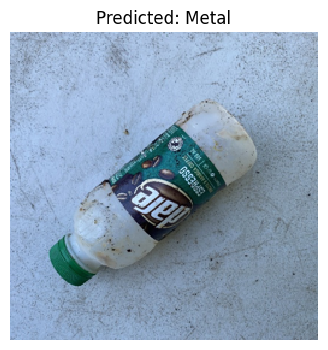

Predicted class index: 2
Predicted class name: "Metal"


In [13]:
def predict_class(image_path, model, class_names, num_px=256):
    """
    Function to predict the class of an image and return the class name, while displaying the image.
    
    Parameters:
    - image_path: str, path to the image to be predicted.
    - model: trained Keras model.
    - class_names: list of str, names of classes corresponding to model output indices.
    - num_px: int, pixel dimension to resize the image to (assuming square images).

    Returns:
    - predicted_class_name: str, name of the predicted class.
    """
    # Load and preprocess the image
    image = Image.open(image_path).resize((num_px, num_px))
    image_array = np.array(image) / 255.0  # Normalize pixel values
    image_input = image_array.reshape((1, num_px, num_px, 3))  # Add batch dimension

    # Predict using the model
    predictions = model.predict(image_input)
    
    # Get the index of the highest probability
    predicted_class_index = np.argmax(predictions[0])
    
    # Retrieve the class name from class_names using the predicted index
    predicted_class_name = class_names[predicted_class_index]

    # Display the image with the predicted class name
    plt.imshow(image_array)
    plt.title(f"Predicted: {predicted_class_name}")
    plt.axis('off')
    plt.show()

    # Print the prediction result
    print(f"Predicted class index: {predicted_class_index}")
    print(f"Predicted class name: \"{predicted_class_name}\"")
    
    return predicted_class_name

# Example usage:
# Assuming `train_y_names` holds the names of the classes corresponding to indices 0–8.
print(classes)
image_path = "D:\ML Projects\CNN Classification\W4A2\Classifier\images\Plastic.jpg"  # Replace with your image path
predicted_class_name = predict_class(image_path, model, classes)
